In [4]:
from dataclasses import dataclass
from typing import List, Optional, Tuple
from pathlib import Path
from astropy.table import Table

import h5py
from xarray import DataArray, Dataset
import numpy as np
from tqdm.auto import tqdm


In [240]:
@dataclass
class SubBand:
    label: str
    filename: Path
    beam_label: str
    in_memory: bool = False
    # data: DataArray
    # flag: DataArray
    # metadata: Dataset
    def __post_init__(self):
        with h5py.File(self.filename, "r") as h5:
            sb_data = f"{self.beam_label}/{self.label}/astronomy_data/data"
            sb_freq = f"{self.beam_label}/{self.label}/astronomy_data/frequency"
            sb_para = f"{self.beam_label}/{self.label}/metadata/obs_params"
            has_flags = (
                "flag" in h5[f"{self.beam_label}/{self.label}/astronomy_data"].keys()
            )
            data = h5[sb_data]
            if has_flags:
                flag = h5[f"{self.beam_label}/{self.label}/astronomy_data/flag"]
                # Ensure flag has same shape as data
                flag_reshape = flag[:].copy()
                for i, s in enumerate(data.shape):
                    if i > len(flag_reshape.shape) - 1:
                        flag_reshape = np.expand_dims(flag_reshape, axis=-1)
                    else:
                        if flag_reshape.shape[i] == s:
                            continue
                        else:
                            flag_reshape = np.expand_dims(flag_reshape, axis=i)
                flag = flag_reshape
            else:
                flag = np.zeros_like(data)
            freq = h5[sb_freq]
            meta = h5[sb_para][:]
            meta_tab = Table(meta)
            if self.in_memory:
                data = np.array(data)
                freq = np.array(freq)
                flag = np.array(flag)
            names = meta.dtype.names
            coords = {name: ("time", meta[name]) for name in names}
            coords["frequency"] = freq
            dims = h5[sb_data].attrs["DIMENSION_LABELS"]

            # Need to isel beam 0 here - it will always be dimension 0
            data_xr = DataArray(
                data,
                dims=dims,
                coords=coords,
                name=f"{self.label}_data",
            ).isel(beam=0)
            flag_xr = DataArray(
                flag,
                dims=dims,
                coords=coords,
                name=f"{self.label}_flag",
            ).isel(beam=0)

            self.data = data_xr
            self.flag = flag_xr
            self.metadata = meta_tab.to_pandas()

@dataclass
class Beam:
    label: str
    filename: Path
    in_memory: bool = False

    def __post_init__(self):
        with h5py.File(self.filename, "r") as f:
            sb_avail = Table.read(f, path=self.label + "/metadata/band_params")
            self.subbands = [
                SubBand(
                    label=sb, 
                    filename=self.filename, 
                    beam_label=self.label,
                    in_memory=self.in_memory,
                ) for sb in sb_avail["LABEL"]
            ]
            for sb in self.subbands:
                self.__dict__[sb.label] = sb


@dataclass
class MetaData:

    filename: Path

    def __post_init__(self):
        with h5py.File(self.filename, "r") as f:
            meta = f["metadata"]
            self.beam_params = pd.DataFrame(np.array(meta["beam_params"]))
            self.history = pd.DataFrame(np.array(meta["history"]))
            self.primary_header = Table(np.array(meta["primary_header"]))

@dataclass
class SDHDF:

    filename: Path
    in_memory: bool = False

    def __post_init__(self):
        self.metadata = MetaData(self.filename)
        with h5py.File(self.filename, "r") as f:
            keys = list(f.keys())
            self.beams = [
                Beam(
                    label=key, 
                    filename=self.filename,
                    in_memory=self.in_memory,
                ) for key in keys if "beam_" in key
            ]
            for beam in self.beams:
                self.__dict__[beam.label] = beam


In [241]:
fname = Path("~/data/parkes/uwl_200406_121917.extract.hdf").expanduser()
data = SDHDF(fname)

In [242]:
data.metadata.primary_header

DATE,HDR_DEFN,HDR_DEFN_VERSION,FILE_FORMAT,FILE_FORMAT_VERSION,SCHED_BLOCK_ID,CAL_MODE,INSTRUMENT,OBSERVER,PID,RECEIVER,TELESCOPE,UTC_START,N_BEAMS
bytes19,bytes5,bytes3,bytes3,bytes3,int64,bytes3,bytes6,bytes6,bytes5,bytes3,bytes6,bytes19,int64
2020-04-07-10:47:10,SDHDF,1.9,HDF,5.0,10654,OFF,Medusa,and460,P1017,UWL,Parkes,2020-04-06-12:19:17,1


In [206]:
import pandas as pd

In [208]:
with h5py.File(fname, "r") as f:
    print(pd.DataFrame(f["metadata"]["primary_header"][:]))

                     DATE  HDR_DEFN HDR_DEFN_VERSION FILE_FORMAT  \
0  b'2020-04-07-10:47:10'  b'SDHDF'           b'1.9'      b'HDF'   

  FILE_FORMAT_VERSION  SCHED_BLOCK_ID CAL_MODE INSTRUMENT   OBSERVER  \
0              b'5.0'           10654   b'OFF'  b'Medusa'  b'and460'   

        PID RECEIVER  TELESCOPE               UTC_START  N_BEAMS  
0  b'P1017'   b'UWL'  b'Parkes'  b'2020-04-06-12:19:17'        1  


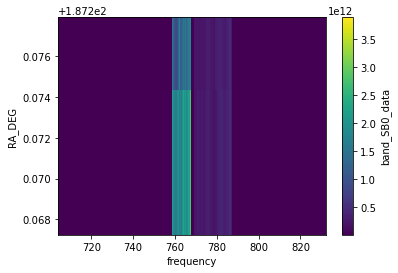

In [193]:
data.beam_0.subbands[0].data.isel(polarization=0).plot(y="RA_DEG")

In [128]:
import matplotlib.pyplot as plt

In [136]:
data.beam_0.band_SB0

SubBand(label='band_SB0', filename=PosixPath('/Users/tho822/data/parkes/uwl_200406_121917.extract.hdf'), beam_label='beam_0', in_memory=False)

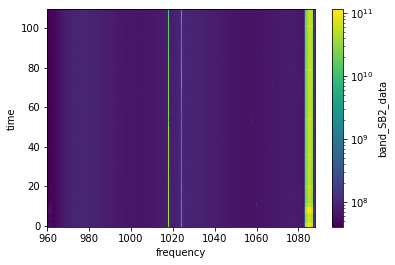

In [182]:
data.beam_0.band_SB2.data.isel(polarization=0, bin=0).plot(norm=plt.cm.colors.LogNorm())

In [12]:
data.beams.beam_0

AttributeError: 'Beams' object has no attribute 'beam_0'